# Assessment 1 for PDS 2024

## Step 0 - getting the data

In [20]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd

first_time = False
if first_time:
    driver = webdriver.Chrome()
    driver.get("https://en.wikipedia.org/wiki/Gun_death_and_violence_in_the_United_States_by_state")


    table = driver.find_element(By.XPATH, "//table[contains(@class, 'wikitable')]")
    headers = [
        'Location',
        'Gun suicide rate',
        'Suicide rate',
        'Gun homicide rate',
        'Homicide rate',
        '% Gun at home']

    # Extract rows
    data = []
    for row in table.find_elements(By.TAG_NAME, "tr")[1:]:
        cells = row.find_elements(By.TAG_NAME, "td")
        if cells:
            data.append([cell.text.strip() for cell in cells])
    df_gun = pd.DataFrame(data, columns=headers)

    driver.quit()

    df_gun.to_csv("wikipedia_table.csv", index=False)

else:
    df_gun =pd.read_csv("wikipedia_table.csv")

In [21]:
## bit of an ugly clean-up job, but I had issues with doing it more elegantly
import numpy as np

df_gun["% Gun at home"] = df_gun["% Gun at home"].replace(["[a]", "[d]"], np.nan)
df_gun["Gun homicide rate"] = df_gun["Gun homicide rate"].replace(["[c]", "[b]"], np.nan)
df_gun = df_gun.dropna()
df_gun[["% Gun at home", "Gun homicide rate"]] = df_gun[["% Gun at home", "Gun homicide rate"]].replace("%", "", regex=True).astype(float)

##Some  of the columns werent numeric
for col in df_gun.columns[1:]:
    df_gun[col] = pd.to_numeric(df_gun[col], errors='coerce')

df_gun.head()

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home
1,Wyoming,23.7,32.8,1.7,2.8,61.0
2,Montana,21.6,31.7,2.7,4.2,65.0
3,Alaska,19.4,30.0,4.2,6.7,57.0
4,New Mexico,14.4,25.2,10.9,14.5,36.0
5,Oklahoma,13.8,22.0,6.4,8.6,55.0


## Exercise 1

### 1a)
Make histograms of each of the variables. Calculate the mean and median of
the gun homicide rate for all the states. Which state has the minimum while
still having some data?

In [22]:
# regulating all plot sizes
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (4, 2)
sns.set_context("notebook", rc={"figure.figsize": (4, 2)})


In [23]:
min_homicide_rate = df_gun["Gun homicide rate"].min()
min_rows = df_gun.loc[df_gun["Gun homicide rate"] == min_homicide_rate].Location.values[0]
print(f"{min_rows} has the minimum gun homicide rate of {min_homicide_rate}")

median =round(df_gun["Gun homicide rate"].median(), 2)
mean =round(df_gun["Gun homicide rate"].mean(), 2)

print(f"The median is {median}, and the mean is {mean}")


Maine has the minimum gun homicide rate of 0.9
The median is 5.1, and the mean is 6.06


### making the histograms (With estimated kernel density for the distribution estimation)

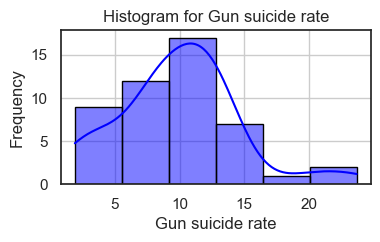

Gun suicide rate


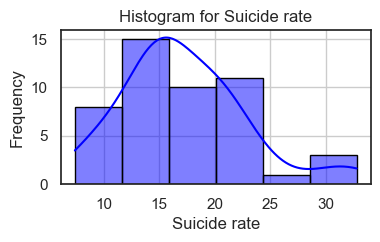

Suicide rate


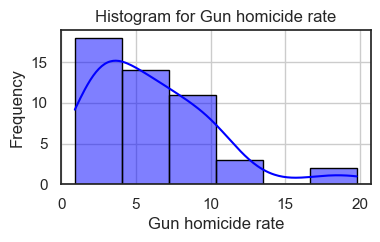

Gun homicide rate


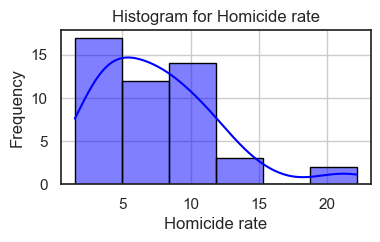

Homicide rate


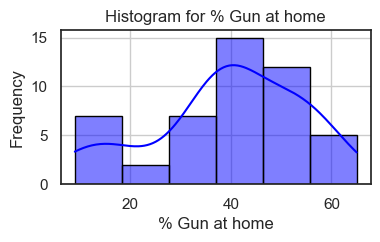

% Gun at home


In [24]:
import matplotlib.pyplot as plt

# Sturge's rule for the optimal bin amount is best for small datasets
# https://www.statology.org/sturges-rule/
opt_bin_size = int(np.log2(52)+1)

for col in df_gun.columns[1::]:
    plt.figure()
    sns.histplot(df_gun[col], bins=opt_bin_size, kde=True, color="blue", edgecolor="black")
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    print(col)


## 1b)
What is the odds ratio between the homicide rate in the USA and the Netherlands?
You will need to look up and cite where you find the gun homicide rate for
both. Interpret this value. Could you have used the mean from all the states?

The formular for the Odds ratio:

$OR = (A/B)/(C/D)$

A = Gun homicides total NE — 85 [3] <br>
B = Inhabitants NE — 18,300,040 [4]

C = Gun homicides total USA — 20,958[1]<br>
D= Inhabitants USA — 346,543,400 [2]

1. https://en.wikipedia.org/wiki/Gun_violence_in_the_United_States#:~:text=In%202021%2C%20a%20little%20above,the%20highest%20percentage%20since%202001.
2. https://www.worldometers.info/world-population/us-population/
3. https://worldpopulationreview.com/country-rankings/gun-deaths-by-country
4. https://www.worldometers.info/world-population/netherlands-population/#google_vignette




In [25]:
A = 85
B =18300040
C =20958
D =346543400

## we dont subtract the gun homicides here, as they would not make a significant difference from the population
OR = (A/B)/(C/D)

OR

0.07680238075690325

### What does that tell us?

As the OR = 0.0768 that mean 1—OR= 0.923, which can be interpreted as a 92% reduction in risk, but as this alone doesn't tell us a bunch, we would also have to take a look at the absolute risks as well as the Odds ratio

_*Could we have used the mean from all of the states?*_ <br>
We could have, but as the mean is quite susceptible to outliers, this may have skewed the results


## 1c)
Can you generate a table of the odds for the best 5 states where you have
values for gun homicide rate? Treat gun homicide rate as an expected
frequency.


In [26]:
df_gun["Gun Homicide odds"] = (df_gun["Gun homicide rate"]/100000)/(1-(df_gun["Gun homicide rate"]/100000))
## for the highest as best ist ambiguous
df_gun_odds = df_gun.sort_values(by='Gun Homicide odds', ascending=False, inplace=False).head()
df_gun_odds

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home,Gun Homicide odds
21,Mississippi,11.3,16.3,19.8,22.2,54.0,0.000198
27,Louisiana,10.0,14.9,17.4,20.4,52.0,0.000174
12,Alabama,12.4,16.4,12.9,14.8,53.0,0.000129
4,New Mexico,14.4,25.2,10.9,14.5,36.0,0.000109
24,South Carolina,10.5,15.5,10.7,12.6,45.0,0.000107


In [27]:
## for the lowest
df_gun_odds = df_gun.sort_values(by='Gun Homicide odds', ascending=True, inplace=False).head()
df_gun_odds

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home,Gun Homicide odds
19,Maine,11.5,20.2,0.9,1.5,48.0,0.000009
50,Massachusetts,1.9,8.6,1.4,2.3,9.0,0.000014
6,Idaho,13.8,20.4,1.5,2.2,58.0,0.000015
47,Hawaii,2.9,14.0,1.6,2.7,9.0,0.000016
1,Wyoming,23.7,32.8,1.7,2.8,61.0,0.000017


___
___

## Exercise 2

### 2a)
Generate the mean and standard deviation for the Netherlands for life
expectancy and infant mortality from 2000 to 2015

In [28]:
df_Gap = pd.read_csv("Gapminder_1900-2017_by_yr.csv")
df_ndl = df_Gap[(df_Gap["country"] == "Netherlands") & (df_Gap["year"] >= 2000) & (df_Gap["year"] <= 2015)]

In [29]:
mean_infant = df_ndl["infant.mortality_per1000"].mean()
mean_infant

4.106249999999999

In [30]:
std_infant = df_ndl["infant.mortality_per1000"].std()
std_infant

0.6444312738117748

In [31]:
mean_life_exp = df_ndl["life.expectancy"].mean()
mean_life_exp

79.981875

In [32]:
std_life_exp = df_ndl["life.expectancy"].std()
std_life_exp

1.2077870604263552

### 2b)
Make a line plot of the infant mortality between 2000 and 2015

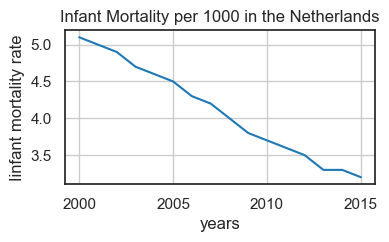

In [33]:
plt.figure()
sns.lineplot(y= df_ndl["infant.mortality_per1000"], x= range(2000,2016) )
plt.title(f"Infant Mortality per 1000 in the Netherlands")
plt.xlabel("years")
plt.ylabel("Iinfant mortality rate")
plt.grid(True)
plt.show()

## 3
### 3a)
Make a plot of age decade against BMI for the
NHANES dataset (nhanes_2000 in Future Learn – can download it there if you
want). Make the dots be filled and slightly transparent alongside the box plot.
In a separate figure, create a violin plot, no need for dots.


In [34]:
df_NH2000 = pd.read_csv("NHANES-2000.csv")
df_NH2000.head()

,SurveyYr,ID,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,...,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation
0,2011_12,63549,female,5,0-9,NaN,Black,Black,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011_12,64871,female,49,40-49,NaN,White,White,CollegeGrad,Married,...,16.0,No,NaN,No,Yes,16.0,25.0,1.0,No,Heterosexual
2,2011_12,70551,male,37,30-39,NaN,White,White,SomeCollege,Married,...,NaN,No,NaN,No,Yes,16.0,10.0,1.0,No,Heterosexual
3,2011_12,66033,female,37,30-39,NaN,White,White,9_11thGrade,Married,...,12.0,Yes,14.0,Yes,Yes,15.0,60.0,1.0,Yes,Heterosexual
4,2011_12,69958,male,12,10-19,NaN,White,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


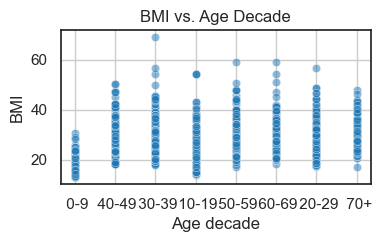

In [35]:
## create scatterplot after requirements
plt.figure()
sns.set_style("white")
sns.scatterplot(y= df_NH2000["BMI"], x= df_NH2000["AgeDecade"], alpha =0.5 )
plt.title(f"BMI vs. Age Decade")
plt.xlabel("Age decade")
plt.ylabel("BMI")
plt.grid(True)
plt.show()

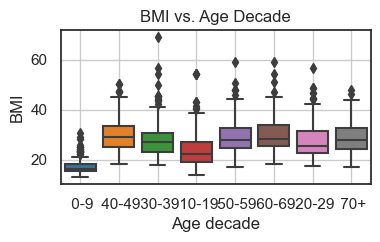

In [36]:
plt.figure()
sns.set_style("white")
sns.boxplot(y= df_NH2000["BMI"], x= df_NH2000["AgeDecade"])
plt.title(f"BMI vs. Age Decade")
plt.xlabel("Age decade")
plt.ylabel("BMI")
plt.grid(True)
plt.show()

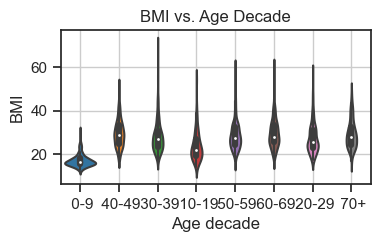

In [37]:
# Violinplot
plt.figure()
sns.set_style("ticks")
sns.violinplot(y= df_NH2000["BMI"], x= df_NH2000["AgeDecade"])
plt.title(f"BMI vs. Age Decade")
plt.xlabel("Age decade")
plt.ylabel("BMI")
plt.grid(True)
plt.show()

## 3b)
   ### i)
   Make a visualization that helps you see the distribution of household
incomes (variable HHIncome) across races (variable Race1).

_I chose HHIncomeMid instead of HHIncome, as to create a plot the values must be numeric and the mid values from the same DS may be the best representation instead of creating a custom method to convert to numeric_

In [38]:

## Clean up HHIncome
df_NH2000["HHIncomeMid"].replace("NA", np.nan, inplace=True)


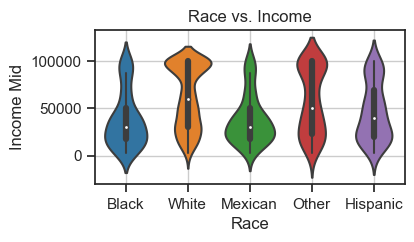

In [39]:
plt.figure()
sns.set_style("ticks")
sns.violinplot(y= df_NH2000["HHIncomeMid"], x= df_NH2000["Race1"])
plt.title(f"Race vs. Income")
plt.xlabel("Race")
plt.ylabel("Income Mid")
plt.grid(True)
plt.show()

   ### ii)

What percentage of White people and Mexican people have an
income between 20k to 25k and what percentage have an income
between 65k to 75k relative to the total number of White/Mexican
households? Give exact values.

In [40]:
white_count_total = (df_NH2000["Race1"] == "White").sum()
white_bet_20_25 = ((df_NH2000["Race1"] == "White") & (df_NH2000["HHIncomeMid"] == 22500)).sum()

white_perc_20 =round((white_bet_20_25/white_count_total)*100)

Mexican_count_total = (df_NH2000["Race1"] == "Mexican").sum()
Mexican_bet_20_25 = ((df_NH2000["Race1"] == "Mexican") & (df_NH2000["HHIncomeMid"] == 22500)).sum()

Mexican_perc_20 =round((Mexican_bet_20_25/Mexican_count_total)*100)

print(f" {white_perc_20}% of white people have a HH income between 20-25 \n"
      f"{Mexican_perc_20}% of mexican people have a HH income between 20-25")


 5% of white people have a HH income between 20-25 
12% of mexican people have a HH income between 20-25


In [41]:
white_bet_65_75 = ((df_NH2000["Race1"] == "White") & (df_NH2000["HHIncomeMid"] == 70000)).sum()

white_perc_65_75 =round((white_bet_65_75/white_count_total)*100)

Mexican_bet_65_75 = ((df_NH2000["Race1"] == "Mexican") & (df_NH2000["HHIncomeMid"] == 70000)).sum()

Mexican_perc_65_75 =round((Mexican_bet_65_75/Mexican_count_total)*100)

print(f" {white_perc_65_75}% of white people have a HH income between 65-75 \n"
      f"{Mexican_perc_65_75}% of mexican people have a HH income between 65-75")

 6% of white people have a HH income between 65-75 
5% of mexican people have a HH income between 65-75


## 3d)

I chose the USA and Malaysia. Two countries that i would have never put into one class when it comes ot infant mortality.
One claiming to be the most advanced country on earth and the other one known for its rainforest and it turns out theyre on a very similar level, with Malaysia having the to be expected higher infant mortality in the past but now having a steeper decrease then the US

## 3e)

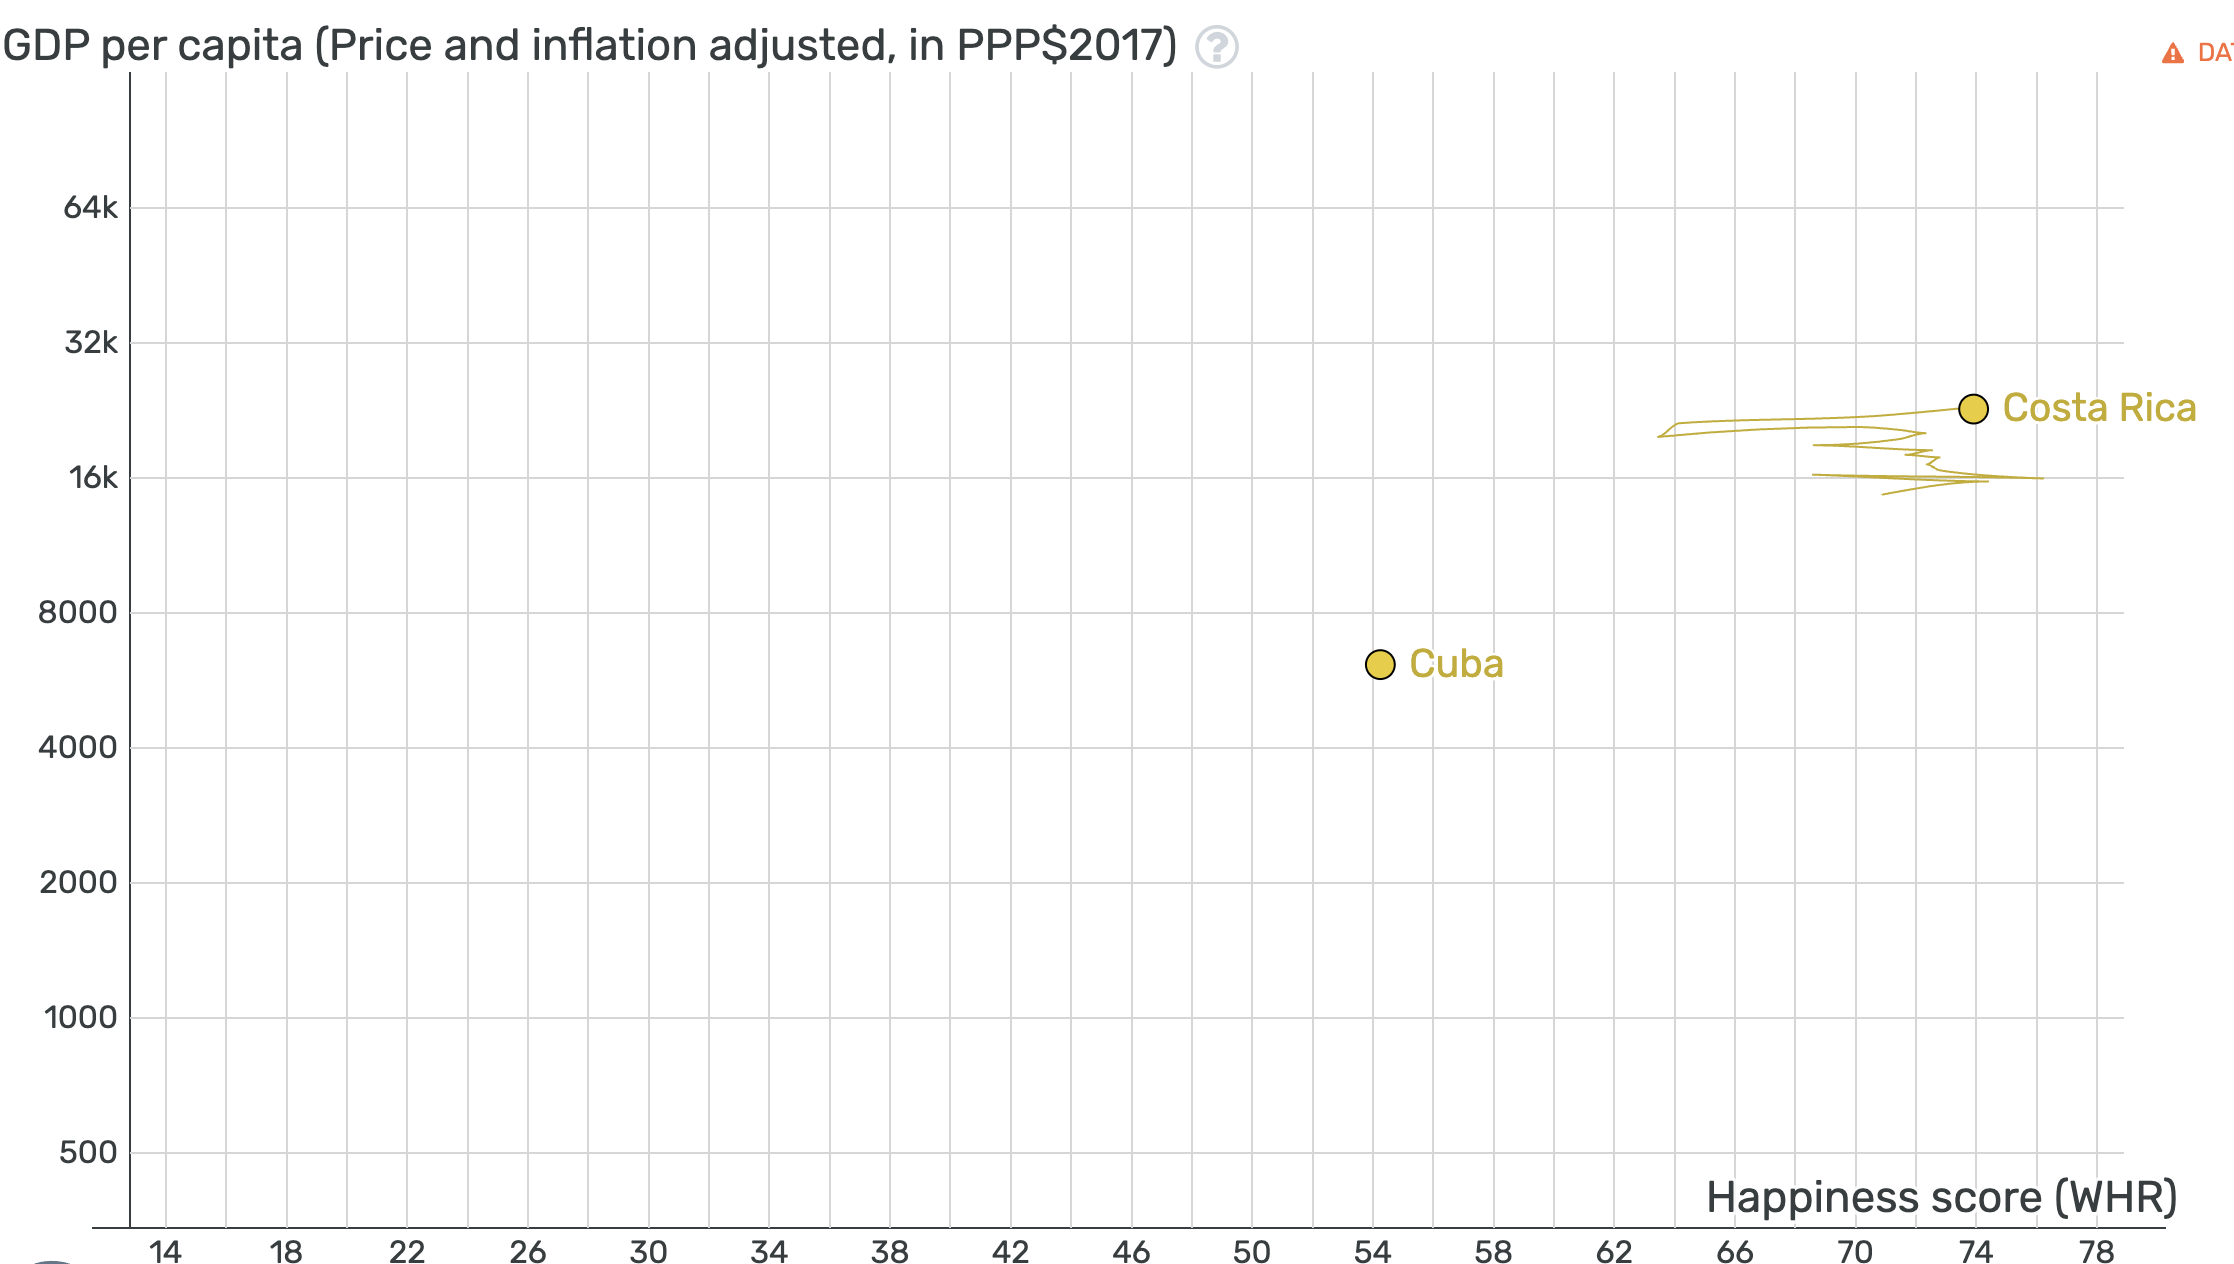

In [42]:
from IPython.display import Image
Image(filename="3e.png", width=500, height=300)


## 4
### Creating purposely bad charts

1. Donut Charts make it difficult to derive meaningful insights due to the lack of a baseline and the inability to quickly compare values. As the number of unique categories increases, readability worsens. Even with just five groups, the chart is already approaching its limit.

2. Word Clouds suffer from similar issues as pie charts, making it nearly impossible to determine whether differences are meaningful, relevant, or significant. Longer words may appear more prominent regardless of frequency, distorting interpretation. Additionally, word clouds lack the ability to compare multiple datasets simultaneously, a task better suited to stacked bar charts.

3. Radial Bar Charts hinder comparison as they lack a clear point of reference, making it hard to gauge differences between groups. This issue is exacerbated when categories extend in opposite directions. In the example provided, a dominant category overshadows the others, making it nearly impossible to discern which group is the second most significant or by how much.

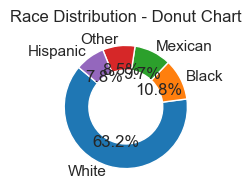

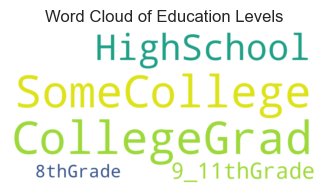

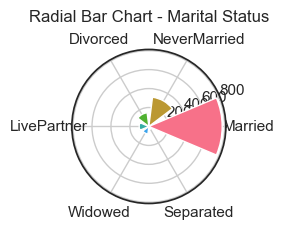

In [43]:
from wordcloud import WordCloud


# Donut Chart - Race Distribution
race_counts = df_NH2000["Race1"].value_counts()
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
plt.title("Race Distribution - Donut Chart")
plt.show()

# Word Cloud - Education Levels
edu_text = " ".join(df_NH2000["Education"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(edu_text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Education Levels")
plt.show()

# Radial Bar Chart - Marital Status
marital_counts = df_NH2000["MaritalStatus"].value_counts()
angles = np.linspace(0, 2 * np.pi, len(marital_counts), endpoint=False)
fig, ax = plt.subplots(figsize=(2, 2), subplot_kw={"projection": "polar"})
ax.bar(angles, marital_counts, tick_label=marital_counts.index, color=sns.color_palette("husl", len(marital_counts)))
ax.set_title("Radial Bar Chart - Marital Status", pad=20)
plt.show()


## 5)
*What is the data, sample, study population and target population for the following
cases: <br>
a. How is gun violence in the USA changing over time? <br>
b. How can I judge if the birth length of a baby is abnormal?* <br>
for A:

    1. Data: police reports, hospital records, surveys
    2. Sample: well chosen sample locations, that are diverse in the location and socio econmic backgrounds,
            maybe even political affiliaton
    3. study population: all gun violence incidents which were reported or witnessed
    4. target populaton: All gun violence nation wide

for B:

    1. Data: measurements of birth lengths taken in hospitals
    2. Sample: A subset defined by location and time maybe including additional possible factors such as the socioeconmic background of the parents
    3. study population: All newborns that were in the study
    4. target populaton: All newborns that fall at least partially in the sample, or have similar conditions ans the kids in the sample

## 6)
Finding nonsensical correlations in the NHANES dataset


In [48]:
## finding something in brute forcing
brute_it = False
if brute_it:
    columns = df_NH2000.columns
    for dependant in columns[2::]:
        for independent in columns[2::]:
            if dependant == independent:
                continue
            plt.figure()
            sns.set_style("ticks")
            sns.lineplot(y= df_NH2000[dependant], x= df_NH2000[independent])
            plt.title(f"Nonsensical correlations")
            plt.xlabel(independent)
            plt.ylabel(dependant)
            plt.grid(True)
            plt.show()

## calculations
calculation = True
if calculation:
    numeric_data = df_NH2000.select_dtypes(include="number")
    columns = numeric_data.columns

    high_corr_pairs = []
    threshold = 0.8

    for dependant in columns:
        for independent in columns:
            if dependant == independent:
                continue
            corr_value = df_NH2000[dependant].corr(df_NH2000[independent])
            if abs(corr_value) > threshold:
                high_corr_pairs.append((dependant, independent, corr_value))

NHANES-2000 turns out to be a bad place to find nonsensical correlations, as it represents a data set of Health-related topics (e.g. Diabetes, depression, and BMI) and comparing these to other facts of life as in the sexual orientation, age, race, height and income groups would very unlikely give und nonsensical correlations and in a complex system as our bodies nonsensical correlations are incredibly hard to discern from sensical ones without proper training and expertise. I will also take a different approach and focus more on the actual correlation itself rather than its visual representation
<br>
<br>
*finding nonsensical correlations in the Gapminder-1900-2017_by_yr dataset*:

In [45]:
## getting only numeric data:
numeric_data = df_Gap.select_dtypes(include="number")
columns = numeric_data.columns

high_corr_pairs = []
threshold = 0.8

for dependant in columns:
    for independent in columns:
        if dependant == independent:
            continue
        corr_value = df_Gap[dependant].corr(df_Gap[independent])
        if abs(corr_value) > threshold:
            high_corr_pairs.append((dependant, independent, corr_value))


There are a few interesting correlations in here, but the most are to be expected!


In [46]:
df_school = pd.read_csv("Census.at.School.500_ages9-15.csv")
numeric_data = df_school.select_dtypes(include="number")
columns = numeric_data.columns

high_corr_pairs = []
threshold = 0.8

for dependant in columns:
    for independent in columns:
        if dependant == independent:
            continue
        corr_value = df_school[dependant].corr(df_school[independent])
        if abs(corr_value) > threshold:
            high_corr_pairs.append((dependant, independent, corr_value))

high_corr_pairs


[('age', 'year', 0.9227050147323741), ('year', 'age', 0.9227050147323741)]

There isn't anything nonsensical in here that is highly correlated that isnt obvious

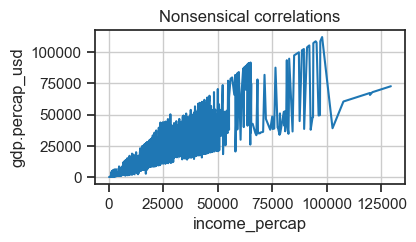

0.9027
0.8083


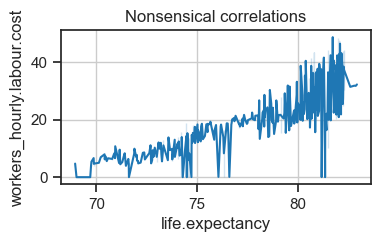

In [47]:
## The highlights of what I found

plt.figure()
sns.lineplot(y= df_Gap["gdp.percap_usd"], x= df_Gap["income_percap"])
plt.title(f"Nonsensical correlations")
plt.grid(True)
plt.show()
correlation = df_Gap["gdp.percap_usd"].corr(df_Gap["income_percap"])
print(round(correlation, 4))

plt.figure()
sns.lineplot(y= df_Gap["workers_hourly.labour.cost"], x= df_Gap["life.expectancy"])
plt.title(f"Nonsensical correlations")
correlation = df_Gap["workers_hourly.labour.cost"].corr(df_Gap["life.expectancy"])
print(round(correlation, 4))

plt.grid(True)
plt.show()


### Possible lurking factors to consider
Plot 1: Since the GDP per capita and the income per capita measure a fairly similar parameter, I would anticipate a correlation for the first plot that is very close to 1. This discrepancy might result from inheritance rather than hard-earned money.

<br>
Plot 2: The hourly pay can have some influence in the life expectancy, but not as much i believe it shows and it also shouldn't have these seemingly random dips in the graph. The underlying connecting factor could be access to healthcare and education

## 7)
Design a randomized control trial to assess whether large language models are
making everyone in the university a little bit more incapable of thinking for
themselves (critical reasoning)

### Step one - asking a concrete question
   - Does the Usage of LLMs by Students at university decrease the their ability to critically reason?
### Step two - Defining the study type
   -  A randomized control trial, where only evaluators are blinded to the groups
      - this ensures that there arent any personal biases towards a specific group and whether they should succeed in the Exams or not
### Step three - Population and sampling
   - As out study population is the entire university student base we have to choose a diverse subset of different fields of studies, including STEM, Humanities, Education and Business, from different universities as well as diverse ages and study progress, under grads as well as grads in an age range that in the average would describe a typical university age range.
      - There will be three groups:
          1. Forbidden from using any LLMs
          2. limited access to LLMs - Either by time or by processing power
          3. Encouraged to use LLMs with free access to state of the art models
      - These Groups must be the same size and must be very similarly diverse, so the output data is as comparable as possible
### Step four - execution
   1. Students will be advised on which group they are in and will also either be granted access or be forbidden from using LLMs
   2. Students will do their day to day with having to fill out a survey at the end of each week about if they used LLMs, if they believed it helped them and if they had to utilize critical thinking this week on a scale of 1-10
   3. Students will write their own exams in their respective fields and will report beforehand how well they feel they're prepared
   4. Students will write a exam designed by the study team that covers a diverse range of critical thinking topics
   5. Students that have reported that their use of LLMs has changed will also grant access to previous grades

### Step 5 - evaluation
   1. Students performance on the survey team's exam will be evaluated ( weighted more strongly)
   2. studetns performance on their own exams will be evaluated (weighted less for this study)
      - If group1 (No LLMs) has performed the best, then we know LLMs are at least not beneficient
      - If group2 (Some LLMs) has performed the best, then we know Usage of LLMs can be beneficiant
      - if group3 (LLMs) has performed the best, then we can conclude that LLMs improve critical thinking

        * if the ranking is 1-2-3 then we know the more we rely on LLMs, the worse our critical thinking is
        * if the ranking is 2-3-1 then we know LLMs are beneficial, but best in limited usage
        * if the ranking is 3-1-2 then we know that LLMs are only useful in full utilization
        * if the ranking is 3-2-1 then we know that LLMs are definitely beneficient
        * if the ranking is 1-3-2 then we know that LLMs no matter in which amount of use do not benefit
        * if the ranking is 2-1-3 then we know that LLMs only help in slight usage
        * if there isnt any order then we know that LLMs do not make a difference

      - The extent of the the order and the spacing between groups will determine how well these statements hold
      - The reports will also show how well we can critically reason about ourselves
      - for students that changed their usage: comparison will give an insight into change over time
  ### Step 6 - repitition?
   - Should we repeat the process for the next years?

#### Data, sample, study population, target population
1. Grades of the students in comparison to each other and to previous work
2. Samples from different faculties, different educational backgrounds, and different universities
3. All students in modern times that could use LLMs for their study
4. All Humans with access to LLMs



## 8)
> GenAI to boost India's IT industry's productivity by up to 45%, EY India survey shows
> > MUMBAI, Feb 10 (Reuters) - The increasing use of generative artificial intelligence (GenAI) could boost the productivity of India's $254-billion software by 43%-45% over the next five years, according to a survey by consulting firm EY India.
This productivity boost, which EY India's survey states will span 500 roles, will come through the dual effect of the IT industry itself integrating elements of GenAI internally and as more client projects move from proof of concept to production.Within the sprawling IT industry, EY India's survey showed that roles in software development will get the biggest productivity boost, of roughly 60%, followed by a 52% improvement for BPO services and 47% for IT consulting.
This trio -- software development, BPO services and IT consulting -- will account for 50%-60% of the overall productivity improvement in tech services, the survey showed.
The increasing use of AI is not only helping the IT industry enhance customer service but is also lowering costs and improving revenue growth, according to executives surveyed by EY India.


An article on [Reuters.com]("https://www.reuters.com/technology/artificial-intelligence/genai-boost-indias-it-industrys-productivity-by-up-45-ey-india-survey-shows-2025-02-10/) asserts that generative AI can increase productivity in the Indian IT sector by up to 45%. The article backs this up with a survey conducted by the consulting firm EY.
This claim, in my opinion, might be exaggerated because it makes a wide generalisation, and the software development, BPO, and IT consulting industries are all extremely distinct from one another and should be evaluated by using various standards.
Furthermore, EY may be biassed since, as an IT consulting company, it stands to gain from claiming that consulting is getting more effective in order to attract more potential clients.
Another problem is that there is no mention of the technique, which leaves one wondering how factual the survey could be

* *_What is the claim:_* GenAI boots India's IT industry's productivity by 45%
* *_What is the evidence provided to support the claim:_* A study by EY, that might be biased as EY itself stands to gain from claims of incredible increases in efficiency through GenAI
* *_Have they overstated the claim:_* The claim is not directly overstated but through the biases that are to be expected by EY standing to gain from these claims, these high numbers should be evaluated carefully.
    * This then seems to be a situation where statistics are used to covertly advertise rather than inform